In [2]:
import zipfile
import os

zip_file_path = '/content/archive (1).zip'
unzip_dir = '/content/archive(1)'

# Create the directory if it doesn't exist
if not os.path.exists(unzip_dir):
    os.makedirs(unzip_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import csv
from sklearn.metrics import rand_score, adjusted_rand_score, normalized_mutual_info_score

In [6]:
import os
import numpy as np
from skimage.io import imread

# Define the path to the COIL-20 dataset
data_dir = '/content/archive(1)/coil-20/coil-20-proc'  # Replace with the correct path

# Object classes in COIL-20
# COIL-20 contains 20 object classes named obj1, obj2, ..., obj20
class_names = [f'obj{i}' for i in range(1, 21)]

# Function to load COIL-20 images
def load_coil20_images():
       coil20_data = []
       for i in range(1, 21):
           for j in range(0, 71):
               image = imread(f'/content/archive(1)/coil-20/coil-20-proc/obj{i}__{j}.png')
               coil20_data.append(image)
       print("Number of images loaded:", len(coil20_data))  # Add this line
       return np.array(coil20_data)

# Load images
images = load_coil20_images()


Number of images loaded: 1420


In [11]:
# Local Binary Pattern (LBP) feature extraction
def extract_lbp_features(image, radius=3, n_points=24):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp.ravel()

# Histogram of Oriented Gradients (HOG) feature extraction
def extract_hog_features(image):
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return hog_features

# Combine all features
def extract_features(images):
    features = []
    for img in images:
        lbp_features = extract_lbp_features(img)
        hog_features = extract_hog_features(img)
        combined_features = np.hstack((lbp_features, hog_features))
        features.append(combined_features)
    return np.array(features)

features = extract_features(images)
print("Extracted features:", features.shape)

Extracted features: (1420, 24484)


In [13]:
# Apply PCA to reduce the dimensionality
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=50)  # Adjust based on experimentation
features_pca = pca.fit_transform(features_scaled)
print("PCA applied. Shape:", features_pca.shape)

PCA applied. Shape: (1420, 50)


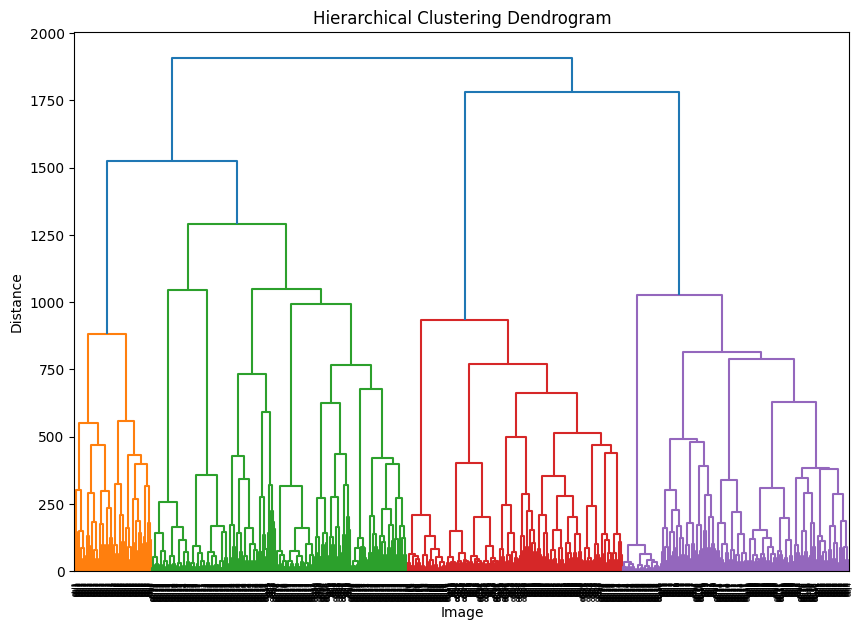

In [17]:
# Perform Hierarchical Clustering
linkage_matrix = linkage(features_pca, method='ward')

# Create labels for the dendrogram (e.g., image filenames or class names)
# Assuming you want to use object classes as labels:
# COIL-20 has 72 images per class, and there are 20 object classes (total 1440)
# The linkage matrix represents 1420 points which matches the number of images.
# Hence, we need 1420 labels, not 1440.

num_images_per_class = 72  # COIL-20 has 72 images per class
num_classes = 20  # Total 20 object classes in COIL-20
labels = [f'obj{i + 1}' for i in range(num_classes) for _ in range(num_images_per_class)]
# Ensure that the length of labels is the same as the number of observations used for clustering
labels = labels[:features_pca.shape[0]]

# Create Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=labels)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Image")
plt.ylabel("Distance")
plt.show()

In [19]:
# Agglomerative Clustering to obtain clusters
agg_cluster = AgglomerativeClustering(n_clusters=7, linkage='ward')
cluster_labels = agg_cluster.fit_predict(features_pca)

# Create a dictionary to store objects in each cluster
clusters = {i: [] for i in range(7)}  # Assuming 7 clusters

# Populate the clusters dictionary
for i, label in enumerate(cluster_labels):
    clusters[label].append(labels[i])

# Print the clusters and their contents
for cluster, objects in clusters.items():
    print(f"Cluster {cluster}:")
    # Count occurrences of each object in the cluster
    object_counts = {obj: objects.count(obj) for obj in set(objects)}
    # Sort objects by count (descending) and then by name
    sorted_objects = sorted(object_counts.items(), key=lambda x: (-x[1], x[0]))
    for obj, count in sorted_objects:
        print(f"  {obj}: {count} images")
    print()  # Empty line for readability

Cluster 0:
  obj7: 72 images
  obj4: 68 images
  obj8: 64 images
  obj11: 61 images
  obj16: 56 images
  obj10: 54 images
  obj15: 15 images
  obj9: 10 images
  obj5: 7 images
  obj6: 6 images
  obj3: 3 images

Cluster 1:
  obj17: 61 images
  obj13: 59 images
  obj18: 27 images
  obj10: 18 images
  obj9: 18 images
  obj16: 16 images
  obj12: 12 images
  obj19: 8 images
  obj3: 8 images
  obj5: 8 images
  obj6: 6 images

Cluster 2:
  obj19: 62 images
  obj3: 58 images
  obj6: 57 images
  obj5: 55 images
  obj20: 52 images
  obj18: 43 images
  obj9: 42 images
  obj17: 11 images
  obj8: 8 images
  obj4: 4 images
  obj2: 2 images

Cluster 3:
  obj1: 72 images
  obj2: 70 images

Cluster 4:
  obj12: 60 images
  obj11: 11 images

Cluster 5:
  obj14: 58 images
  obj13: 13 images
  obj3: 3 images
  obj6: 3 images
  obj18: 2 images
  obj19: 2 images
  obj5: 2 images
  obj9: 2 images

Cluster 6:
  obj15: 57 images
  obj14: 14 images



Cluster 0:
  10_0: obj10
  11_1: obj11
  15_2: obj15
  16_3: obj16
  j3_4: obj3
  j4_5: obj4
  j5_6: obj5
  j6_7: obj6
  j7_8: obj7
  j8_9: obj8
  j9_10: obj9


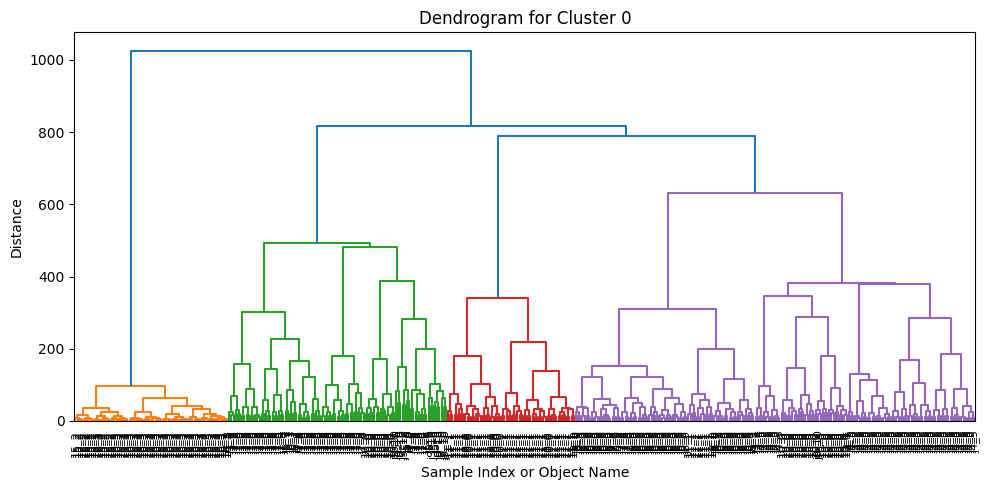



Cluster 1:
  10_0: obj10
  12_1: obj12
  13_2: obj13
  16_3: obj16
  17_4: obj17
  18_5: obj18
  19_6: obj19
  j3_7: obj3
  j5_8: obj5
  j6_9: obj6
  j9_10: obj9


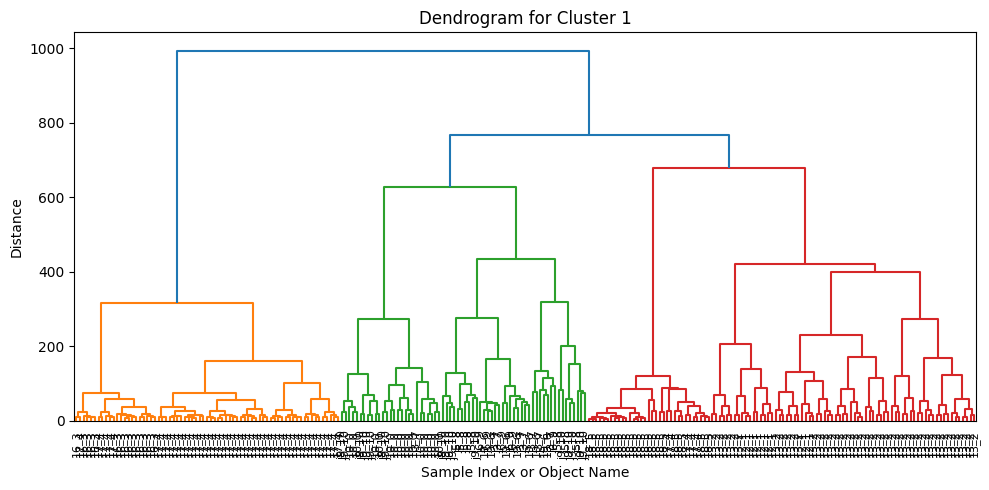



Cluster 2:
  17_0: obj17
  18_1: obj18
  19_2: obj19
  j2_3: obj2
  20_4: obj20
  j3_5: obj3
  j4_6: obj4
  j5_7: obj5
  j6_8: obj6
  j8_9: obj8
  j9_10: obj9


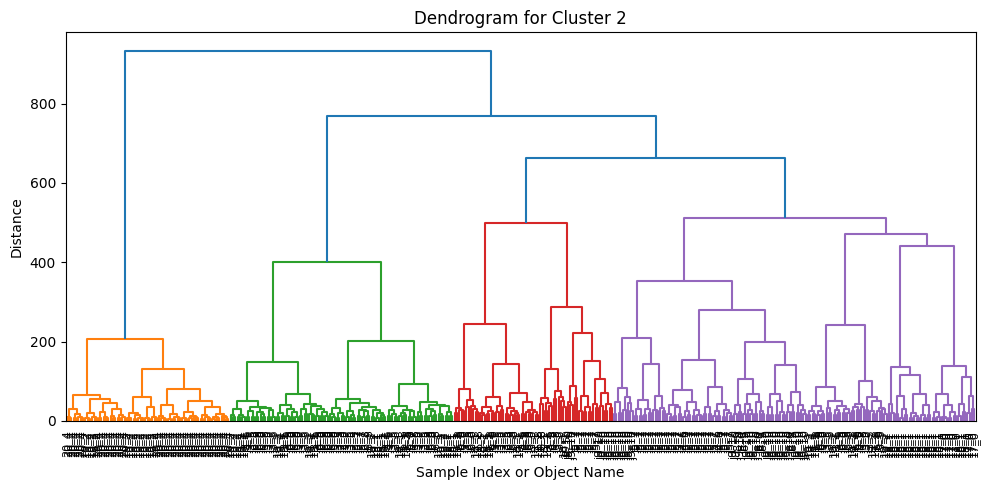



Cluster 3:
  j1_0: obj1
  j2_1: obj2


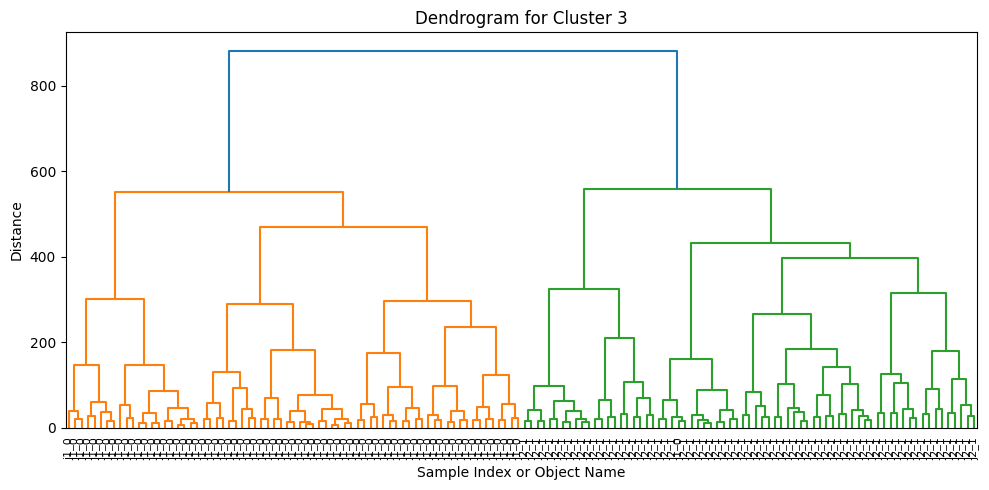



Cluster 4:
  11_0: obj11
  12_1: obj12


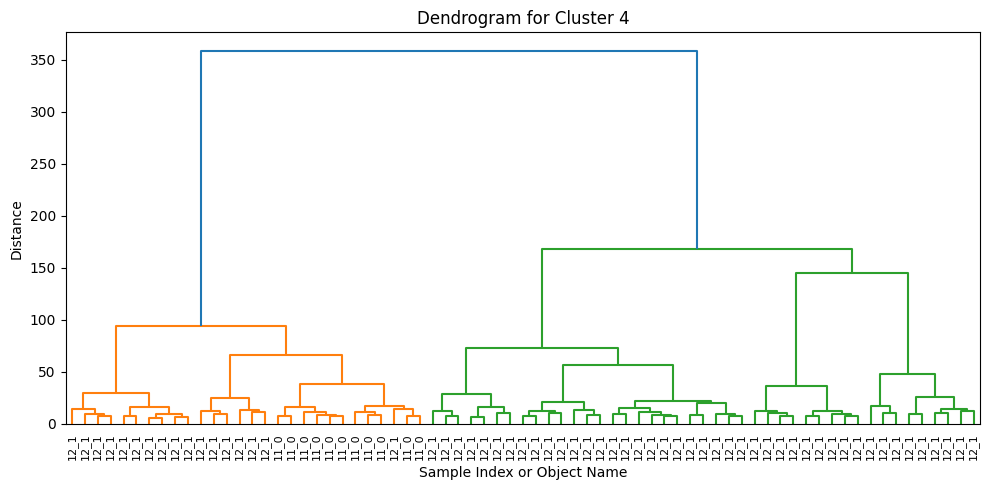



Cluster 5:
  13_0: obj13
  14_1: obj14
  18_2: obj18
  19_3: obj19
  j3_4: obj3
  j5_5: obj5
  j6_6: obj6
  j9_7: obj9


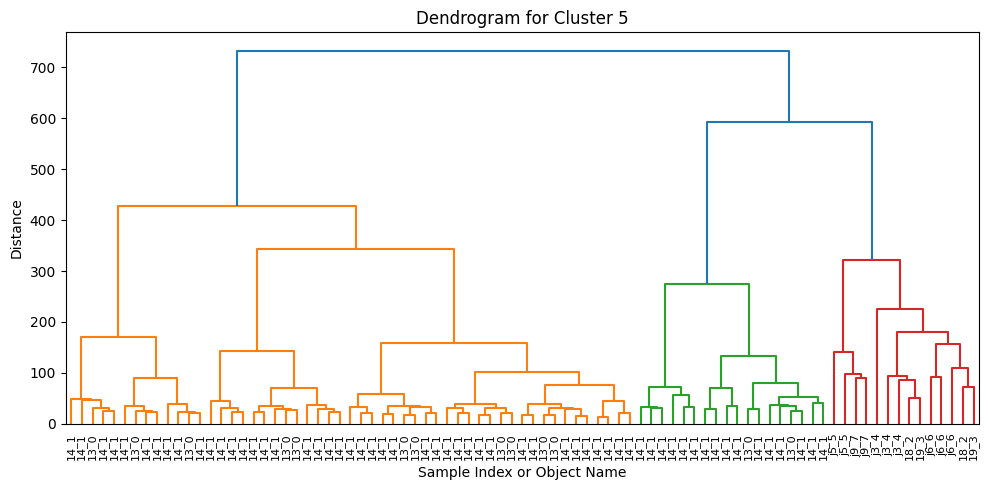



Cluster 6:
  14_0: obj14
  15_1: obj15


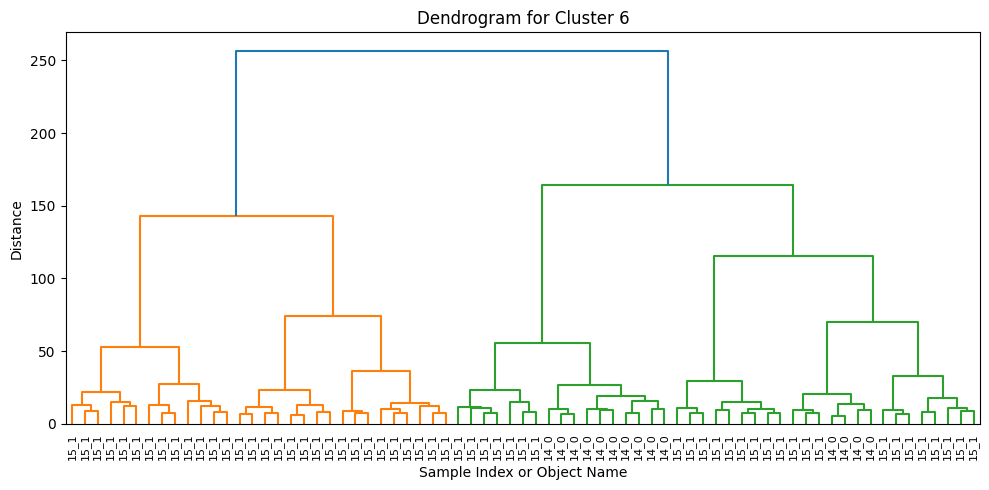

In [22]:
# Perform Agglomerative Clustering
n_clusters = 7
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_cluster.fit_predict(features_pca)

# Function to plot dendrogram for a single cluster
def plot_cluster_dendrogram(cluster_data, cluster_labels, cluster_num):
    linkage_matrix = linkage(cluster_data, method='ward')

    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix, labels=cluster_labels, leaf_rotation=90, leaf_font_size=8)
    plt.title(f'Dendrogram for Cluster {cluster_num}')
    plt.xlabel('Sample Index or Object Name')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

# Create separate dendrograms for each cluster
for i in range(n_clusters):
    # Get data and labels for this cluster
    cluster_mask = cluster_labels == i
    cluster_data = features_pca[cluster_mask]
    cluster_object_labels = labels[cluster_mask]

    # Create a mapping of full labels to shorter labels for readability
    unique_labels = sorted(set(cluster_object_labels))
    label_mapping = {label: f"{label[-2:]}_{j}" for j, label in enumerate(unique_labels)}
    short_labels = [label_mapping[label] for label in cluster_object_labels]

    print(f"Cluster {i}:")
    for full_label, short_label in label_mapping.items():
        print(f"  {short_label}: {full_label}")

    # Plot dendrogram for this cluster
    plot_cluster_dendrogram(cluster_data, short_labels, i)
    print("\n")  # Add some space between cluster outputs

In [23]:
import csv
import os
from sklearn.cluster import AgglomerativeClustering

# Assuming you have already performed PCA and have features_pca and labels

# Perform Agglomerative Clustering
n_clusters = 7
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_cluster.fit_predict(features_pca)

# Create a dictionary to store cluster information
clusters = {i: [] for i in range(n_clusters)}

# Populate the clusters dictionary
for i, (label, cluster) in enumerate(zip(labels, cluster_labels)):
    clusters[cluster].append((i, label))

# Specify the output file name
output_file = 'cluster_contents.csv'

# Write cluster contents to CSV
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write header
    writer.writerow(['Cluster', 'Image Index', 'Object Label'])

    # Write data for each cluster
    for cluster, contents in clusters.items():
        for image_index, object_label in contents:
            writer.writerow([cluster, image_index, object_label])

print(f"Cluster contents have been written to {output_file}")

# Optional: Print a summary of cluster sizes
print("\nCluster sizes:")
for cluster, contents in clusters.items():
    print(f"Cluster {cluster}: {len(contents)} images")

Cluster contents have been written to cluster_contents.csv

Cluster sizes:
Cluster 0: 416 images
Cluster 1: 241 images
Cluster 2: 394 images
Cluster 3: 142 images
Cluster 4: 71 images
Cluster 5: 85 images
Cluster 6: 71 images


In [29]:
# Generate image identifiers and populate the clusters dictionary
for i, (label, cluster) in enumerate(zip(labels, cluster_labels)):
    obj_class = (i // 72) + 1  # 72 images per object, 20 objects
    img_number = i % 72
    image_id = f"obj{obj_class}__{img_number:02d}.png"
    clusters[cluster].append((image_id, f"obj{obj_class}"))

# Specify the output file name
output_file = 'cluster_contents.csv'

# Write cluster contents to CSV
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write header
    writer.writerow(['Cluster', 'Image ID', 'Object Class'])

    # Write data for each cluster
    for cluster, contents in clusters.items():
        for image_id, object_class in contents:
            writer.writerow([cluster, image_id, object_class])

print(f"Cluster contents have been written to {output_file}")

# Optional: Print a summary of cluster sizes
print("\nCluster sizes:")
for cluster, contents in clusters.items():
    print(f"Cluster {cluster}: {len(contents)} images")

# Optional: Print explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print("\nCumulative Explained Variance Ratio:")
print(cumulative_variance_ratio)
print(f"Total variance explained by 50 components: {cumulative_variance_ratio[-1]:.4f}")

Cluster contents have been written to cluster_contents.csv

Cluster sizes:
Cluster 0: 142 images
Cluster 1: 312 images
Cluster 2: 309 images
Cluster 3: 142 images
Cluster 4: 373 images
Cluster 5: 71 images
Cluster 6: 71 images

Cumulative Explained Variance Ratio:
[0.0715581  0.13252314 0.17219965 0.19699037 0.219268   0.23604721
 0.25265651 0.26777433 0.28047124 0.29246198 0.30370624 0.31312342
 0.32141819 0.32927473 0.33671204 0.3436408  0.34973406 0.35568295
 0.36133413 0.36664295 0.37146141 0.37615324 0.38055478 0.38486473
 0.38887746 0.39275808 0.39654451 0.40029356 0.40393084 0.40740154
 0.41068115 0.41385396 0.41697758 0.41993358 0.42283911 0.42571328
 0.42844734 0.43113925 0.43377729 0.43635957 0.43892666 0.44142243
 0.44388267 0.4463141  0.44868582 0.45101173 0.45328615 0.45553996
 0.45777031 0.45992992]
Total variance explained by 50 components: 0.4599


In [32]:
# Calculate Rand Index, ARI, and NMI
true_labels = np.array([i // 72 for i in range(len(labels))])  # Assuming 72 images per object
rand_index = rand_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("\nClustering Evaluation Metrics:")
print(f"Rand Index: {rand_index:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

# ... (rest of the code for writing to CSV and printing cluster sizes)

# Append metrics to the CSV file
with open(output_file, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([])  # Add an empty row for separation
    writer.writerow(['Metric', 'Value'])
    writer.writerow(['Rand Index', f"{rand_index:.4f}"])
    writer.writerow(['Adjusted Rand Index', f"{ari:.4f}"])
    writer.writerow(['Normalized Mutual Information', f"{nmi:.4f}"])

print(f"Evaluation metrics have been appended to {output_file}")


Clustering Evaluation Metrics:
Rand Index: 0.8313
Adjusted Rand Index: 0.2325
Normalized Mutual Information: 0.5547
Evaluation metrics have been appended to cluster_contents.csv
